
## R에서 간단한 처리 이후 이쪽으로 분석 진행. 
### 처리내역 :
#### Outlier 및 NA observation 처리 : 
* 4분 이하, 4000분 이상 데이터 삭제
* confidence NA 변수 5000여개 삭제
* Salary 중 Student가 높은 salary 갖는 몇 안되는 개체 삭제
* gender = 총 4개의 그룹 중 2개의 small class의 개체들이 다른 패턴 보유, 삭제
* salary = I do not want to disclose 개체 삭제

#### 변수 One Hot Encoding : 
* 기존에 One Hot Encoding 되어있는 변수들은 0, 1 로 재코딩
* class를 보유하고 있는 단일변수들은 one hot encoding (get_dummies) 하여 여러 변수로 나누어줌. (ex - Role, Industry, gender, ...)
* 척도형 변수를 갖는 단일 변수도 예외없이 one hot encoding 시킴
* Q34, Q35 = 변수설명상 합쳐서 100이 되는 변수 - 각 개체 값이 1 이하가 되도록 100으로 나눠줌
* 변수 설명상 0~3의 값을 적는 변수 - 각 개체 값이 1 이하가 되도록 3으로 나눠줌. 
* 7_Student : industry = Student인 경우와 Role = Student인 경우가 중첩되어 Industry = Student 변수 삭제. 

#### 삭제한 변수 내역 : 
* Q41 - 앞의 모든 경우에서 collinearity가 발견되어 삭제. 
* Q34 : 일반적으로 데이터 사이언스 프로젝트 진행 시 각 업무별로 소요되는 시간 비중 => 앞의 모든 경우에서 변수가 유의하게 나와 한번 빼고 진행. 
* Q43 : 진행한 data projects 중 데이터셋내의 'unfair bias'의 탐구와 관련이 있었던 프로젝트의 비율 => 너무 많은 class로 제거
* Q44 : fair 하고 unbiased 한 알고리즘을 확실히 하는 데 가장 많은 어려움을 주는 항목 : 복수 응답 : ex. difficulty in identifying groups that are unfairly targeted. => 역시 너무 많은 class로 제거. 
* (앞의 경우 Q43, Q44 모두 Variable Importance 20 내에 들지 못함) 

#### Target Variabel Salayr 변형 : 
* 총 19개의 multiclass를 가지고 있어, multiclassification 하게 되면 성능이 너무 낮아지는 문제가 발생하여 상위 20%에게 1, 하위 80%에게 0 label을 갖는 top_20 변수를 새로 생성함. 





In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
multiple = pd.read_csv("/content/drive/My Drive/multiple.csv", low_memory = False)

In [ ]:
qschema = pd.read_csv("/content/drive/My Drive/SurveySchema.csv")

In [ ]:
multiple.head()

,duration,gender,Age,country,degree,undergraduate_major,Role,industry,Experience,value,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_Part_13,Q13_Part_14,Q13_Part_15,Q14_Part_1,Q14_Part_2,...,Q45_Part_5,Q45_Part_6,Q46,Q47_Part_1,Q47_Part_2,Q47_Part_3,Q47_Part_4,Q47_Part_5,Q47_Part_6,Q47_Part_7,Q47_Part_8,Q47_Part_9,Q47_Part_10,Q47_Part_11,Q47_Part_12,Q47_Part_13,Q47_Part_14,Q47_Part_15,Q47_Part_16,Q48,Q49_Part_1,Q49_Part_2,Q49_Part_3,Q49_Part_4,Q49_Part_5,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
0,718,Female,30-34,NorthAmerica,Master’s degree,"Computer science (software engineering, etc.)",Student,Student,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,-1,-1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10-20,NaN,Examine feature correlations,Examine feature importances,NaN,NaN,NaN,NaN,Plot predicted vs. actual results,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I am confident that I can explain the outputs ...,NaN,NaN,NaN,NaN,NaN,NaN,Make sure the code is human-readable,Define all random seeds,NaN,Include a text file describing all dependencies,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
1,731,Male,22-24,Asia,Master’s degree,Mathematics or statistics,Student,Student,0-1,"0-10,000",I do not know,NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,1,-1,-1,-1,NaN,RStudio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20-30,NaN,NaN,NaN,NaN,Create partial dependence plots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I am confident that I can understand and expla...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Define relative rather than absolute file paths,NaN,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
2,1142,Male,25-29,SouthAmerica,Bachelor’s degree,Physics or astronomy,Data Scientist,Computers/Technology,0-1,I do not wish to disclose my approximate yearl...,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,NaN,-1,-1,-1,2,-1,Jupyter/IPython,NaN,NaN,NaN,NaN,Atom,NaN,NaN,NaN,NaN,Vim,NaN,NaN,NaN,NaN,Kaggle Kernels,Google Colab,...,When first exploring a new ML model or dataset,NaN,0,NaN,Examine feature correlations,Examine feature importances,NaN,NaN,NaN,NaN,Plot predicted vs. actual results,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"I view ML models as ""black boxes"" but I am con...",Share code on Github or a similar code-sharing...,Share both data and code on Github or a simila...,"Share data, code, and environment using a host...",NaN,"Share code, data, and environment using virtua...",Make sure the code is well documented,Make sure the code is human-readable,NaN,NaN,Include a text file describing all dependencies,NaN,NaN,NaN,NaN,NaN,Afraid that others will use my work without gi...,NaN,I had never considered making my work easier f...,NaN,NaN
3,751,Male,30-34,Europe,Master’s degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,3-4,"20-30,000","We have well established ML methods (i.e., mod...",NaN,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,NaN,-1,-1,-1,4,-1,Jupyter/IPython,NaN,PyCharm,Visual Studio Code,NaN,NaN,NaN,Visual Studio,NaN,Sublime Text,NaN,IntelliJ,NaN,NaN,NaN,Kaggle Kernels,NaN,...,When first exploring a new ML model or dataset,NaN,50-60,NaN,Examine feature correlations,NaN,NaN,NaN,Dimensionality reduction techniques,NaN,Plot predicted vs. actual r

In [ ]:
## drop Nan in salary
#multiple = multiple[~multiple.value.isnull()].copy()
not_disclosed = multiple[multiple.value == 'I do not wish to disclose my approximate yearly compensation'].index
#multiple = multiple.drop(list(not_disclosed), axis=0)
print(not_disclosed)

Int64Index([    2,     4,    12,    19,    22,    25,    35,    41,    68,
               81,
            ...
            14070, 14071, 14073, 14076, 14079, 14080, 14082, 14086, 14087,
            14091],
           dtype='int64', length=3510)


In [ ]:
from pandas.api.types import CategoricalDtype

In [ ]:
multiple.dtypes

duration       int64
gender        object
Age           object
country       object
degree        object
               ...  
Q50_Part_4    object
Q50_Part_5    object
Q50_Part_6    object
Q50_Part_7    object
Q50_Part_8    object
Length: 346, dtype: object

In [ ]:
multiple.columns

Index(['duration', 'gender', 'Age', 'country', 'degree', 'undergraduate_major',
       'Role', 'industry', 'Experience', 'value',
       ...
       'Q49_Part_11', 'Q49_Part_12', 'Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3',
       'Q50_Part_4', 'Q50_Part_5', 'Q50_Part_6', 'Q50_Part_7', 'Q50_Part_8'],
      dtype='object', length=346)

In [ ]:
multiple.iloc[:,319:321]

,Q47_Part_11,Q47_Part_12
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,ELI5 functions
...,...,...
14087,NaN,NaN
14088,NaN,NaN
14089,NaN,NaN
14090,NaN,NaN


## Another Dataset : 
* Student가 I do not disclose my compensation의 45%를 차지
* gender 2개에서 이상치 생김. 아예 drop하는게? 
* Students 패턴 제거 (수입 적음) 

In [ ]:
gender_trolls = multiple[(multiple.gender == 'Prefer to self-describe') | (multiple.gender == 'Prefer not to say')].index
multiple = multiple.drop(list(gender_trolls), axis=0)

In [ ]:
student_trolls = multiple[((multiple.Role == 'Student') & (multiple.value > '500,000+')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '400-500,000')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '300-400,000')) | \
                     ((multiple.Role == 'Student') & (multiple.value > '250-300,000'))].index
multiple = multiple.drop(list(student_trolls), axis=0)

In [ ]:
multiple = multiple[~multiple.value.isnull()].copy()
not_disclosed = multiple[multiple.value == 'I do not wish to disclose my approximate yearly compensation'].index
multiple = multiple.drop(list(not_disclosed), axis=0)

In [ ]:
multiple.value[1:10]

1        0-10,000
3       20-30,000
5     125-150,000
8       10-20,000
9       30-40,000
10      50-60,000
11      30-40,000
13       0-10,000
14      70-80,000
Name: value, dtype: object

In [ ]:
question = multiple.columns

In [ ]:
question[100:300]

Index(['Q21_Part_8', 'Q21_Part_9', 'Q21_Part_10', 'Q21_Part_11', 'Q21_Part_12',
       'Q21_Part_13', 'Q23', 'Q24', 'Q25', 'confidence',
       ...
       'Q42_Part_1', 'Q42_Part_2', 'Q42_Part_3', 'Q42_Part_4', 'Q42_Part_5',
       'Q43', 'Q44_Part_1', 'Q44_Part_2', 'Q44_Part_3', 'Q44_Part_4'],
      dtype='object', length=200)

In [ ]:
multiple.dtypes[10:20]

Q10                object
Q11_Part_1         object
Q11_Part_2         object
Q11_Part_3         object
Q11_Part_4         object
Q11_Part_5         object
Q11_Part_6         object
Q11_Part_7         object
Q12_Part_1_TEXT     int64
Q12_Part_2_TEXT     int64
dtype: object

## One Hot Encoding : 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
sns.set_style('dark')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Role : 

In [ ]:
len(multiple.Role[multiple.Role.isna()])

0

In [ ]:
roledummy = pd.get_dummies(multiple.Role)

In [ ]:
roledummy.head()

,Business Analyst,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0
8,0,1,0,0,0,0,0


* Q1 - Q10 - gender

In [ ]:
multiple.gender.unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
sex = pd.get_dummies(multiple.gender).iloc[:,:2]
sex.columns=list(map(lambda x:'1_'+x,sex.columns))

In [ ]:
sex[1:10]

,1_Female,1_Male
1,0,1
3,0,1
5,0,1
8,1,0
9,0,1
10,0,1
11,0,1
13,1,0
14,0,1


In [ ]:
ndata = multiple.iloc[:,0]
ndata.head()

0    718
1    731
3    751
5    823
8    846
Name: duration, dtype: int64

In [ ]:
ndata = pd.concat([ndata,sex],axis=1)
ndata.head()

,duration,1_Female,1_Male
0,718,1,0
1,731,0,1
3,751,0,1
5,823,0,1
8,846,1,0


* Q1 - Q10 : 나이

In [ ]:
multiple.Age.unique()

array(['30-34', '22-24', '40-44', '25-29', '55-59', '35-39', '18-21',
       '45-49', '50-54', '60-69', '70-79', '80+'], dtype=object)

In [ ]:
q2=pd.get_dummies(multiple.Age)
q2.columns=list(map(lambda x: '2_'+x,q2.columns))
ndata = pd.concat([ndata,q2],axis=1)

country - one hot encoding 

In [ ]:
multiple.country.unique()

array(['NorthAmerica', 'Asia', 'Europe', 'SouthAmerica', 'Africa',
       'Oceania', nan], dtype=object)

In [ ]:
q3=pd.get_dummies(multiple.country)

In [ ]:
q3.columns=list(map(lambda x: '3_'+x,q3.columns))
ndata = pd.concat([ndata,q3],axis=1)

In [ ]:
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10200 entries, 0 to 14090
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   duration        10200 non-null  int64
 1   1_Female        10200 non-null  uint8
 2   1_Male          10200 non-null  uint8
 3   2_18-21         10200 non-null  uint8
 4   2_22-24         10200 non-null  uint8
 5   2_25-29         10200 non-null  uint8
 6   2_30-34         10200 non-null  uint8
 7   2_35-39         10200 non-null  uint8
 8   2_40-44         10200 non-null  uint8
 9   2_45-49         10200 non-null  uint8
 10  2_50-54         10200 non-null  uint8
 11  2_55-59         10200 non-null  uint8
 12  2_60-69         10200 non-null  uint8
 13  2_70-79         10200 non-null  uint8
 14  2_80+           10200 non-null  uint8
 15  3_Africa        10200 non-null  uint8
 16  3_Asia          10200 non-null  uint8
 17  3_Europe        10200 non-null  uint8
 18  3_NorthAmerica  10200 non-

Degree - 교육수준 one hot encoding! 

In [ ]:
multiple.degree.unique()

array(['Master’s degree', 'Bachelor’s degree',
       'Some college/university study without earning a bachelor’s degree',
       'Doctoral degree', 'Professional degree',
       'No formal education past high school'], dtype=object)

In [ ]:
q4 = pd.get_dummies(multiple.degree)
q4.columns=list(map(lambda x: '4_'+x,q4.columns))
ndata = pd.concat([ndata,q4],axis=1)

* Role 추가 

In [ ]:
ndata = pd.concat([ndata, roledummy], axis=1)

Major in undergraduated : 

In [ ]:
multiple.undergraduate_major.unique()

array(['Computer science (software engineering, etc.)',
       'Mathematics or statistics', 'Engineering (non-computer focused)',
       'A business discipline (accounting, economics, finance, etc.)',
       'Environmental science or geology', 'I never declared a major',
       'Other',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'Physics or astronomy',
       'Information technology, networking, or system administration',
       'Social sciences (anthropology, psychology, sociology, etc.)',
       'Humanities (history, literature, philosophy, etc.)', nan,
       'Fine arts or performing arts'], dtype=object)

In [ ]:
q5 = pd.get_dummies(multiple.undergraduate_major)
q5.columns=list(map(lambda x: '5_'+x,q5.columns))
ndata = pd.concat([ndata,q5],axis=1)

* Industry : 산업군! 

In [ ]:
q7 = pd.get_dummies(multiple.industry)
q7.columns=list(map(lambda x: '7_'+x,q7.columns))
ndata = pd.concat([ndata,q7],axis=1)

* Salary - Target variable! 

* experience 

In [ ]:
q8 = pd.get_dummies(multiple.Experience)
q8.columns=list(map(lambda x: '8_'+x,q8.columns))
ndata = pd.concat([ndata,q8],axis=1)

* Q10 - ML 회사 사용? 

In [ ]:
multiple.columns[1:15]

Index(['gender', 'Age', 'country', 'degree', 'undergraduate_major', 'Role',
       'industry', 'Experience', 'value', 'Q10', 'Q11_Part_1', 'Q11_Part_2',
       'Q11_Part_3', 'Q11_Part_4'],
      dtype='object')

In [ ]:
ndata.shape

(10200, 77)

In [ ]:
# to dummies : 
q10 = pd.get_dummies(multiple.Q10)
q10.columns=list(map(lambda x: '10_'+x,q10.columns))
ndata = pd.concat([ndata,q10],axis=1)

In [ ]:
ndata.shape

(10200, 83)

* Q11

In [ ]:
def to_onehot(i):
    num = 'Q'+str(i)
    q = multiple[[t for t in multiple.columns if num in t]]
    q = q.drop([t for t in q.columns if 'OTHER_TEXT' in t],axis=1)  
    q=q.fillna(0)
    q_r = []
    for col in q.columns:
        if q[col].unique()[0]!=0:
            s = q[col].unique()[0]
            q_r.append(s)
        else:
            s = q[col].unique()[1]
            q_r.append(s)
        q[col]=q[col].replace(s,1)
    q.columns=q_r
    return q

In [ ]:
q11=to_onehot(11)
q11=q11.idxmax(axis=1)
q11.head()

0    Analyze and understand data to influence produ...
1                                                Other
3    Build and/or run a machine learning service th...
5    Build and/or run a machine learning service th...
8    Analyze and understand data to influence produ...
dtype: object

In [ ]:
q11=to_onehot(11)
q11.columns = ['11_'+str(col) for col in q11.columns]

In [ ]:
#Add None of these & Others - to others
q11.iloc[:,-1]=q11.iloc[:,-2]+q11.iloc[:,-1]
q11=q11.drop(q11.columns[-2],axis=1)

In [ ]:
ndata=pd.concat([ndata,q11],axis=1)

## 원래부터 One-Hot Encoding 된 것들 : Nan -> 0로 바꾸기. 

* Q12

In [ ]:
q12=multiple[[t for t in multiple.columns if 'Q12' in t]]
q12=q12.iloc[:,1:]
q12=q12.astype(int) 
q12[q12!=-1]=1
q12[q12==-1]=0
q12.head()

,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT
0,0,0,1,0
1,1,0,0,0
3,0,0,1,0
5,0,1,0,0
8,0,0,0,0


In [ ]:
q12.columns=['12_'+ str(col) for col in q12.columns]
ndata=pd.concat([ndata,q12],axis=1)

* Q13

In [ ]:
def preprocess_multiple(data,i):
    s='Q'+str(i)
    if s+'_OTHER_TEXT' in data.columns:
        data=data.drop([s+'_OTHER_TEXT'],axis=1)
    df=to_onehot(i)
    df.columns=[str(i)+'_'+str(col) for col in df.columns]
    return df

In [ ]:
q13=preprocess_multiple(multiple, 13)
ndata=pd.concat([ndata,q13],axis=1)

In [ ]:
q13.head()

,13_Jupyter/IPython,13_RStudio,13_PyCharm,13_Visual Studio Code,13_nteract,13_Atom,13_MATLAB,13_Visual Studio,13_Notepad++,13_Sublime Text,13_Vim,13_IntelliJ,13_Spyder,13_None,13_Other
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0
5,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
ndata.shape

(10200, 108)

In [ ]:
ndata.iloc[1:5, 60:74]

,7_Online Business/Internet-based Sales,7_Online Service/Internet-based Services,7_Other,7_Retail/Sales,7_Shipping/Transportation,7_Student,8_0-1,8_1-2,8_10-15,8_15-20,8_2-3,8_20-25,8_25-30,8_3-4
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,1,0,0,0,0,0,0


* Q14

In [ ]:
q14=preprocess_multiple(multiple, 14)
ndata=pd.concat([ndata,q14],axis=1)

* Q15 - Q16

In [ ]:
q15=preprocess_multiple(multiple, 15)
ndata=pd.concat([ndata,q15],axis=1)

In [ ]:
q16=preprocess_multiple(multiple, 16)
ndata=pd.concat([ndata,q16],axis=1)

In [ ]:
preprocess_needed = [19, 21]

In [ ]:
ndata2 = ndata.copy()

In [ ]:
for i in preprocess_needed : 
  q = preprocess_multiple(multiple, i)
  ndata2 = pd.concat([ndata2, q], axis = 1)

* Q 23-Q26 : get_dummies

In [ ]:
q23=pd.get_dummies(multiple.Q23)
q23.columns=['23_'+str(col) for col in q23.columns]
ndata2=pd.concat([ndata2,q23],axis=1)

In [ ]:
lst=['I have never written code and I do not want to learn','I have never written code but I want to learn','< 1 year','1-2 years','3-5 years',   '5-10 years',
       '10-20 years', '20-30 years','30-40 years','40+ years']

In [ ]:
q24=pd.get_dummies(multiple.Q24)
q24.columns=['24_'+str(col) for col in q24.columns]
q24=q24.reindex(columns=list(map(lambda x: '24_'+x,lst)))
ndata2=pd.concat([ndata2,q24],axis=1)

* Q25

In [ ]:
multiple.Q25.unique()

array(['< 1 year', '2-3 years', '5-10 years', '1-2 years', '3-4 years',
       'I have never studied machine learning but plan to learn in the future',
       'I have never studied machine learning and I do not plan to',
       '4-5 years', '10-15 years', '20+ years'], dtype=object)

In [ ]:
q25=pd.get_dummies(multiple.Q25)
q25.columns=['25_'+str(col) for col in q25.columns]
ndata2=pd.concat([ndata2,q25],axis=1)

* Q26 : confindence

In [ ]:
tmp = multiple.confidence.copy()
len(tmp[tmp.isna()])

0

In [ ]:
q26=pd.get_dummies(multiple.confidence)
q26.columns=['26_'+str(col) for col in q26.columns]
ndata2=pd.concat([ndata2,q26],axis=1)

In [ ]:
ndata2.head()

,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,2_45-49,2_50-54,2_55-59,2_60-69,2_70-79,2_80+,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,4_No formal education past high school,4_Professional degree,4_Some college/university study without earning a bachelor’s degree,Business Analyst,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Environmental science or geology,5_Fine arts or performing arts,"5_Humanities (history, literature, philosophy, etc.)",...,21_D3,21_Plotly,21_Bokeh,21_Seaborn,21_Geoplotlib,21_Leaflet,21_Lattice,21_None,21_Other,23_0% of my time,23_1% to 25% of my time,23_100% of my time,23_25% to 49% of my time,23_50% to 74% of my time,23_75% to 99% of my time,24_I have never written code and I do not want to learn,24_I have never written code but I want to learn,24_< 1 year,24_1-2 years,24_3-5 years,24_5-10 years,24_10-20 years,24_20-30 years,24_30-40 years,24_40+ years,25_1-2 years,25_10-15 years,25_2-3 years,25_20+ years,25_3-4 years,25_4-5 years,25_5-10 years,25_< 1 year,25_I have never studied machine learning and I do not plan to,25_I have never studied machine learning but plan to learn in the future,26_Definitely not,26_Definitely yes,26_Maybe,26_Probably not,26_Probably yes
0,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,751,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,823,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
8,846,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


* Q27-Q31, Q33, Q36, Q38, Q42, Q44, Q45, Q47, Q49, Q50

In [ ]:
preprocess_needed = [27, 28, 29, 30, 31, 36]

In [ ]:
multiple=multiple.drop(['Q38_Part_19'],axis=1)
multiple=multiple.drop(['Q38_Part_20'],axis=1)

In [ ]:
for i in preprocess_needed : 
  q = preprocess_multiple(multiple, i)
  ndata2 = pd.concat([ndata2, q], axis = 1)

In [ ]:
ndata2.iloc[1:5, 300:310]
ndata2.shape

(10200, 348)

In [ ]:
ndata3 = pd.DataFrame

In [ ]:
ndata3 = ndata2.copy()

In [ ]:
for i in [38,42,44,45,47,49,50] : 
  q = preprocess_multiple(multiple, i)
  ndata3 = pd.concat([ndata3, q], axis = 1)

In [ ]:
ndata3.iloc[1:4, 310:330]

,30_Oracle Exadata,30_Oracle Warehouse Builder,30_SAP IQ,30_Snowflake,30_Databricks,30_Azure SQL Data Warehouse,30_Azure HDInsight,30_Azure Stream Analytics,30_IBM InfoSphere DataStorage,30_IBM Cloud Analytics Engine,30_IBM Cloud Streaming Analytics,30_None,30_Other,31_Audio Data,31_Categorical Data,31_Genetic Data,31_Geospatial Data,31_Image Data,31_Numerical Data,31_Sensor Data
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


* Q32

In [ ]:
multiple=multiple.drop(['Q32_OTHER'],axis=1)

* Q34 : 일반적으로 데이터 사이언스 프로젝트 진행 시 각 업무별로 소요되는 시간 비중  =>  빼기. 



In [ ]:
len(multiple.Q34_Part_1[multiple.Q34_Part_1.isna()]) 

1158

In [ ]:
q34=multiple[[t for t in multiple.columns if 'Q34_' in t]]/100
#ndata3=pd.concat([ndata3,q34],axis=1)

In [ ]:
q34.head()

,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6
0,0.02,0.03,0.2,0.50,0.2,0.00
1,0.10,0.10,0.2,0.10,0.2,0.23
3,0.55,0.10,0.2,0.05,0.0,0.10
5,0.40,0.00,0.0,0.00,0.5,0.10
8,0.00,0.40,0.1,0.30,0.0,0.20


* Q35

In [ ]:
len(multiple.Q35_Part_1[multiple.Q35_Part_1.isna()]) #NA값 마찬가지로 제외하는게 좋을듯

1260

In [ ]:
q35=multiple[[t for t in multiple.columns if 'Q35_' in t]]/100
q35.columns=['35_'+str(col) for col in q35.columns]
ndata3=pd.concat([ndata3, q35],axis=1)

* Q40, Q41, Q43, Q46, Q48

In [ ]:
multiple.Q40.unique()

array(['Independent projects are equally important as academic achievements',
       'Independent projects are slightly more important than academic achievements',
       'Independent projects are much less important than academic achievements',
       'Independent projects are much more important than academic achievements',
       'Independent projects are slightly less important than academic achievements',
       'No opinion; I do not know', nan], dtype=object)

In [ ]:
len(multiple.Q40[multiple.Q40.isna()]) #NA값삭제

1328

In [ ]:
q40=pd.get_dummies(multiple.Q40)
q40.columns=['40_'+str(col) for col in q40.columns]

In [ ]:
ndata3 = pd.concat([ndata3,q40],axis=1)

* Q41 => 제거

In [ ]:
ndata3.head()

,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,2_45-49,2_50-54,2_55-59,2_60-69,2_70-79,2_80+,3_Africa,3_Asia,3_Europe,3_NorthAmerica,3_Oceania,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,4_No formal education past high school,4_Professional degree,4_Some college/university study without earning a bachelor’s degree,Business Analyst,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Environmental science or geology,5_Fine arts or performing arts,"5_Humanities (history, literature, philosophy, etc.)",...,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_ELI5 functions,47_SHAP functions,47_None/I do not use these model explanation techniques,47_Other,47_Visualising and interpreting predicted vs. actual,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,49_None/I do not make my work easy for others to reproduce,49_Other,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,50_Other,35_Q35_Part_1,35_Q35_Part_2,35_Q35_Part_3,35_Q35_Part_4,35_Q35_Part_5,35_Q35_Part_6,40_Independent projects are equally important as academic achievements,40_Independent projects are much less important than academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly less important than academic achievements,40_Independent projects are slightly more important than academic achievements,40_No opinion; I do not know
0,718,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,0
1,731,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0.2,0.4,0.2,0.2,0.0,0.0,0,0,0,0,1,0
3,751,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0.7,0.3,0.0,0.0,0.0,0.0,1,0,0,0,0,0
5,823,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0.0,0.0,0.1,0.8,0.1,0.0,0,1,0,0,0,0
8,846,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.3,0.4,0.0,0.0,0.3,0.0,1,0,0,0,0,0


1 0 Recoding 

In [ ]:
##Q41
encode = {'Very important':3, 'Slightly important':2,
       'Not at all important':1, 'No opinion; I do not know':0}
q41 = multiple[[i for i in multiple.columns if 'Q41_' in i]]
q41 = q41.replace(encode)
q41 = q41.fillna(0)
q41=q41.astype(int) 
q41[q41!=3]=0
q41[q41==3]=1
q41.head()

,Q41_Part_1,Q41_Part_2,Q41_Part_3
0,1,1,1
1,0,0,1
3,0,1,0
5,0,0,1
8,1,0,1


* Q43 : drop - too many classes. 척도형 - 제외

In [ ]:
multiple.Q43.unique()

array(['0-10', '20-30', '10-20', '0', '30-40', nan, '40-50', '90-100',
       '70-80', '50-60', '60-70', '80-90'], dtype=object)

In [ ]:
len(multiple.Q43[multiple.Q43.isna()]) #NA값 삭제

2635

In [ ]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = multiple.Q43.copy()
tmp = tmp.replace(encode)

In [ ]:
q43=pd.get_dummies(multiple.Q43)
q43.columns=['43_'+str(col) for col in q43.columns]
#ndata3=pd.concat([ndata3,q43],axis=1)

* Q46 - drop : too many classes - 제외


In [ ]:
multiple.Q46.unique()

array(['10-20', '20-30', '50-60', '0', '90-100', '0-10', '30-40', nan,
       '70-80', '40-50', '80-90', '60-70'], dtype=object)

In [ ]:
#numeric encoding
encode = {'0-10':1, '20-30':3, '0':0, '10-20':2, '30-40':4, '60-70':7, '40-50':5,
       '90-100':10, '70-80':8, '50-60':6, '80-90':9}
tmp = multiple.Q46.copy()
tmp = tmp.replace(encode)

In [ ]:
q46=pd.get_dummies(multiple.Q46)
q46.columns=['46_'+str(col) for col in q46.columns]
#ndata3=pd.concat([ndata3,q46],axis=1)

* Q48

In [ ]:
multiple.Q48.unique()

array(['I am confident that I can explain the outputs of most if not all ML models',
       'I am confident that I can understand and explain the outputs of many but not all ML models',
       'Yes, most ML models are "black boxes"',
       'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       'I do not know; I have no opinion on the matter', nan],
      dtype=object)

In [ ]:
q48=pd.get_dummies(multiple.Q48)
q48.columns=['48_'+str(col) for col in q48.columns]
ndata3=pd.concat([ndata3,q48],axis=1)

In [ ]:
ndata3.shape

(10200, 438)

## Salary : 

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(multiple.value)
le.classes_

array(['0-10,000', '10-20,000', '100-125,000', '125-150,000',
       '150-200,000', '20-30,000', '200-250,000', '250-300,000',
       '30-40,000', '300-400,000', '40-50,000', '400-500,000',
       '50-60,000', '500,000+', '60-70,000', '70-80,000', '80-90,000',
       '90-100,000'], dtype=object)

In [ ]:
salary = le.transform(multiple.value)
salary = pd.Series(salary)
salary = salary.rename("value")

In [ ]:
len(salary)

10200

In [ ]:
df_labeled = pd.concat([ndata3, salary], axis=1)

In [ ]:
df_labeled.shape

(12856, 439)

* 상위 20% 변수 생성 

In [ ]:
# Define target variable
compensation = multiple.value.str.replace(',', '').str.replace('500000\+', '500-500000').str.split('-')
multiple['yearly_compensation_numerical'] = compensation.apply(lambda x: (int(x[0]) * 1000 + int(x[1]))/ 2) / 1000 # it is calculated in thousand dollars

In [ ]:
top20flag = multiple.yearly_compensation_numerical.quantile(0.8)
print(top20flag)

75.0


In [ ]:
clean_dataset = (multiple.yearly_compensation_numerical > top20flag).reset_index().astype(int)
clean_dataset.columns = ['index', 'top20']

In [ ]:
len(clean_dataset.loc[clean_dataset['top20']==1, :])

1971

In [ ]:
clean_dataset.shape

(10200, 2)

In [ ]:
ndata_top = pd.DataFrame()
ndata_top = ndata3.copy()

In [ ]:
q_overlap = ndata3[[i for i in ndata3.columns if '27_' in i]]
q_overlap.head()

,27_AWS Elastic Compute Cloud (EC2),27_Google Compute Engine,27_AWS Elastic Beanstalk,27_Google App Engine,27_Google Kubernetes Engine,27_AWS Lambda,27_Google Cloud Functions,27_AWS Batch,27_Azure Virtual Machines,27_Azure Container Service,27_Azure Functions,27_Azure Event Grid,27_Azure Batch,27_Azure Kubernetes Service,27_IBM Cloud Virtual Servers,27_IBM Cloud Container Registry,27_IBM Cloud Kubernetes Service,27_IBM Cloud Foundry,27_None,27_Other
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Join with treated questions
for key, value in ndata_top.items():
    value = value.reset_index(drop=True)
    clean_dataset = clean_dataset.join(value, how='left')

In [ ]:
clean_dataset.top20[1:20]

1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    1
16    0
17    1
18    0
19    1
Name: top20, dtype: int64

In [ ]:
multiple.value[1:20]

1        0-10,000
3       20-30,000
5     125-150,000
8       10-20,000
9       30-40,000
10      50-60,000
11      30-40,000
13       0-10,000
14      70-80,000
15       0-10,000
16      80-90,000
17      10-20,000
18      10-20,000
20      70-80,000
21    100-125,000
23      60-70,000
24     90-100,000
26      30-40,000
27      80-90,000
Name: value, dtype: object

In [ ]:
clean_dataset = clean_dataset.drop('index', axis=1)

In [ ]:
df_labeled.columns[399:401]

Index(['47_Other', '47_Visualising and interpreting predicted vs. actual'], dtype='object')

In [ ]:
clean_dataset.shape

(10200, 439)

In [ ]:
[col for col in clean_dataset.columns if '47_' in col]
len(clean_dataset['47_Visualising and interpreting predicted vs. actual'][clean_dataset['47_Visualising and interpreting predicted vs. actual']==1])
clean_dataset = clean_dataset.drop(['47_Visualising and interpreting predicted vs. actual'],axis=1)

In [ ]:
colnames = clean_dataset.columns
colnames[390:410]

Index(['47_Create partial dependence plots',
       '47_Dimensionality reduction techniques',
       '47_Attention mapping/saliency mapping',
       '47_Plot predicted vs. actual results', '47_Print out a decision tree',
       '47_Sensitivity analysis/perturbation importance', '47_LIME functions',
       '47_ELI5 functions', '47_SHAP functions',
       '47_None/I do not use these model explanation techniques', '47_Other',
       '49_Share code on Github or a similar code-sharing repository',
       '49_Share both data and code on Github or a similar code-sharing repository',
       '49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)',
       '49_Share data, code, and environment using containers (Docker, etc.)',
       '49_Share code, data, and environment using virtual machines (VirtualBox, etc.)',
       '49_Make sure the code is well documented',
       '49_Make sure the code is human-readable', '49_Define all r

In [ ]:
percent_answer = clean_dataset.sum(axis=0) / clean_dataset.shape[0]

for row in percent_answer.iteritems():
  if row[1] < 0.05 :
    clean_dataset = clean_dataset.drop(row[0], axis=1)

* Dropping answers that have less than 5% of repondents - to avoid overfitting. 
* 모든 class를 one hot encoding 시켰기 때문에, 5% 미만의 응답을 가진 것도 모두 변수화 되어있다. 
* 이런 부분까지 fitting한다면 이 데이터에 대해서만 overfitting이 일어날 가능성이 크다고 판단해, 총 응답 수가 5%보다 낮은 변수/응답은 모두 제거하였다. 
* + Dimension Reduction 을 위해서 진행. 

In [ ]:
clean_dataset.shape

(10200, 248)

In [ ]:
clean_dataset.head()

,top20,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Student,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,...,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,35_Q35_Part_1,35_Q35_Part_2,35_Q35_Part_3,35_Q35_Part_4,35_Q35_Part_5,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,0,718,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1,0,0,1,0,0,0,0
1,0,731,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0.2,0.4,0.2,0.2,0.0,0,0,1,0,1,0,0,0
2,0,751,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0.7,0.3,0.0,0.0,0.0,1,0,0,0,1,0,0,0
3,1,823,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0.0,0.0,0.1,0.8,0.1,0,0,0,0,1,0,0,0
4,0,846,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0.3,0.4,0.0,0.0,0.3,1,0,0,0,1,0,0,0


In [ ]:
for c in clean_dataset:
    print(c)
    clean_dataset[c]=pd.to_numeric(clean_dataset[c])

top20
duration
1_Female
1_Male
2_18-21
2_22-24
2_25-29
2_30-34
2_35-39
2_40-44
3_Asia
3_Europe
3_NorthAmerica
3_SouthAmerica
4_Bachelor’s degree
4_Doctoral degree
4_Master’s degree
Data Analyst
Data Engineer/DBA
Data Scientist
Software Engineer
Statistician/Research Scientist
Student
5_A business discipline (accounting, economics, finance, etc.)
5_Computer science (software engineering, etc.)
5_Engineering (non-computer focused)
5_Mathematics or statistics
5_Physics or astronomy
7_Academics/Education
7_Accounting/Finance
7_Computers/Technology
7_Student
8_0-1
8_1-2
8_10-15
8_2-3
8_3-4
8_4-5
8_5-10
10_I do not know
10_No (we do not use ML methods)
10_We are exploring ML methods (and may one day put a model into production)
10_We have well established ML methods (i.e., models in production for more than 2 years)
10_We recently started using ML methods (i.e., models in production for less than 2 years)
10_We use ML methods for generating insights (but do not put working models into produc

In [ ]:
clean_dataset.shape

(10200, 248)

* multicollinearity 확인 및 제거

In [ ]:
# Create correlation matrix
correl = clean_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = correl.where(np.triu(np.ones(correl.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.5
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Drop features 
#clean_dataset_dropped = clean_dataset.drop(to_drop, axis=1)

#shape = clean_dataset_dropped.shape
#print('After dropping highly correlated features, our has {} records and {} features'.format(shape[0], shape[1]))
#print('Dropped features: ', to_drop)

In [ ]:
to_drop

['1_Male',
 '4_Master’s degree',
 '7_Student',
 '14_None',
 '15_I have not used any cloud providers',
 '16_R',
 '16_MATLAB',
 '19_Keras',
 '19_None',
 '21_ggplot2',
 '21_Matplotlib',
 '21_None',
 '25_I have never studied machine learning but plan to learn in the future',
 '27_AWS Elastic Compute Cloud (EC2)',
 '27_Google Compute Engine',
 '27_Azure Virtual Machines',
 '29_MySQL',
 '36_Fast.AI',
 '49_Make sure the code is human-readable']

In [ ]:
upper

,top20,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,7_Student,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,...,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,35_Q35_Part_1,35_Q35_Part_2,35_Q35_Part_3,35_Q35_Part_4,35_Q35_Part_5,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
top20,NaN,0.01479,0.000214,0.000214,0.141757,0.183878,0.089317,0.095761,0.141627,0.109398,0.234486,0.113681,0.469818,0.086164,0.098603,0.105985,0.030585,0.029642,0.039011,0.210974,0.025426,0.016107,0.251592,0.042155,0.112244,0.014027,0.031693,0.058032,0.079514,0.067098,0.042554,0.234931,0.132926,0.060661,0.092148,0.010798,0.009223,0.046042,0.081547,0.112628,...,0.138917,0.041484,0.072549,0.090843,0.012364,0.113254,0.069747,0.132248,0.083603,0.051258,0.104433,0.077294,0.002357,0.084807,0.030598,0.129800,0.109595,0.125870,0.124921,0.074595,0.014175,0.069798,0.040428,0.026334,0.056100,0.032995,0.054138,0.010220,0.064355,0.101417,0.004449,0.055740,0.018009,0.019776,0.026657,0.040195,0.106179,0.044039,0.063649,0.005208
duration,NaN,NaN,0.001286,0.001286,0.010575,0.004440,0.004653,0.004419,0.003722,0.006895,0.003190,0.009316,0.017583,0.022101,0.000277,0.010387,0.000563,0.007108,0.012710,0.011967,0.005249,0.019304,0.005569,0.020027,0.019326,0.004555,0.006742,0.003186,0.001679,0.000997,0.013602,0.007244,0.021056,0.014982,0.009559,0.003474,0.009757,0.010200,0.005971,0.007761,...,0.009489,0.008794,0.005378,0.021174,0.025634,0.031141,0.018787,0.009292,0.000609,0.015570,0.019332,0.022232,0.007226,0.020684,0.001501,0.032572,0.034150,0.019830,0.026506,0.044421,0.001972,0.015952,0.001397,0.024133,0.015295,0.004242,0.017968,0.003848,0.023382,0.001477,0.012745,0.009532,0.002569,0.016516,0.009578,0.002857,0.017991,

* 7_Student의 경우 Role = Student와 정확히 일치하기 때문에 변수 제거해줌. 

In [ ]:
clean_dataset = clean_dataset.drop('7_Student', axis=1)

In [ ]:
# Finding NANs
df = clean_dataset.isnull().sum().to_frame()
print('We found {} NaNs on the dataset after treatment'.format(df[df[0] > 0].shape[0]))
## 질문을 날리는게 더 낫지않을까? 유의하게 안나오면 질문 날리고 진행해봅시다. 

We found 5 NaNs on the dataset after treatment


In [ ]:
df[0]

top20                                                                                                     0
duration                                                                                                  0
1_Female                                                                                                  0
1_Male                                                                                                    0
2_18-21                                                                                                   0
                                                                                                         ..
48_I am confident that I can explain the outputs of most if not all ML models                             0
48_I am confident that I can understand and explain the outputs of many but not all ML models             0
48_I do not know; I have no opinion on the matter                                                         0
48_I view ML models as "blac

In [ ]:
df[df[0]>0]

,0
35_Q35_Part_1,1260
35_Q35_Part_2,1260
35_Q35_Part_3,1260
35_Q35_Part_4,1260
35_Q35_Part_5,1260


In [ ]:
for c in clean_dataset:
    if len(clean_dataset[clean_dataset[c].isna()])>0:
        clean_dataset=clean_dataset[~clean_dataset[c].isna()]

In [ ]:
clean_dataset.shape

(8940, 247)

In [ ]:
clean_dataset.head()

,top20,duration,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,10_No (we do not use ML methods),...,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,35_Q35_Part_1,35_Q35_Part_2,35_Q35_Part_3,35_Q35_Part_4,35_Q35_Part_5,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,0,718,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1,0,0,1,0,0,0,0
1,0,731,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0.2,0.4,0.2,0.2,0.0,0,0,1,0,1,0,0,0
2,0,751,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0.7,0.3,0.0,0.0,0.0,1,0,0,0,1,0,0,0
3,1,823,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0.0,0.0,0.1,0.8,0.1,0,0,0,0,1,0,0,0
4,0,846,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0.3,0.4,0.0,0.0,0.3,1,0,0,0,1,0,0,0


In [ ]:
clean_dataset.iloc[:,2:]

,1_Female,1_Male,2_18-21,2_22-24,2_25-29,2_30-34,2_35-39,2_40-44,3_Asia,3_Europe,3_NorthAmerica,3_SouthAmerica,4_Bachelor’s degree,4_Doctoral degree,4_Master’s degree,Data Analyst,Data Engineer/DBA,Data Scientist,Software Engineer,Statistician/Research Scientist,Student,"5_A business discipline (accounting, economics, finance, etc.)","5_Computer science (software engineering, etc.)",5_Engineering (non-computer focused),5_Mathematics or statistics,5_Physics or astronomy,7_Academics/Education,7_Accounting/Finance,7_Computers/Technology,8_0-1,8_1-2,8_10-15,8_2-3,8_3-4,8_4-5,8_5-10,10_I do not know,10_No (we do not use ML methods),10_We are exploring ML methods (and may one day put a model into production),"10_We have well established ML methods (i.e., models in production for more than 2 years)",...,47_Examine feature importances,47_Plot decision boundaries,47_Create partial dependence plots,47_Dimensionality reduction techniques,47_Attention mapping/saliency mapping,47_Plot predicted vs. actual results,47_Print out a decision tree,47_Sensitivity analysis/perturbation importance,47_LIME functions,47_None/I do not use these model explanation techniques,49_Share code on Github or a similar code-sharing repository,49_Share both data and code on Github or a similar code-sharing repository,"49_Share data, code, and environment using a hosted service (Kaggle Kernels, Google Colaboratory, Amazon SageMaker, etc.)","49_Share data, code, and environment using containers (Docker, etc.)","49_Share code, data, and environment using virtual machines (VirtualBox, etc.)",49_Make sure the code is well documented,49_Make sure the code is human-readable,49_Define all random seeds,49_Define relative rather than absolute file paths,49_Include a text file describing all dependencies,50_Too expensive,50_Too time-consuming,50_Requires too much technical knowledge,50_Afraid that others will use my work without giving proper credit,50_Not enough incentives to share my work,50_I had never considered making my work easier for others to reproduce,50_None of these reasons apply to me,35_Q35_Part_1,35_Q35_Part_2,35_Q35_Part_3,35_Q35_Part_4,35_Q35_Part_5,40_Independent projects are equally important as academic achievements,40_Independent projects are much more important than academic achievements,40_Independent projects are slightly more important than academic achievements,48_I am confident that I can explain the outputs of most if not all ML models,48_I am confident that I can understand and explain the outputs of many but not all ML models,48_I do not know; I have no opinion on the matter,"48_I view ML models as ""black boxes"" but I am confident that experts are able to explain model outputs","48_Yes, most ML models are ""black boxes"""
0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0.0,0.00,0.0,1.00,0.0,1,0,0,1,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0.2,0.40,0.2,0.20,0.0,0,0,1,0,1,0,0,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0.7,0.30,0.0,0.00,0.0,1,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0.0,0.00,0.1,0.80,0.1,0,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0.3,0.40,0.0,0.00,0.3,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10190,0,1,0,0,0,1,0,0,1,0

## Modeling 

### Calculating Training Error, Test Error and CV score - 
#### Model Selection Method 1. Using Test error/AUC, 
#### Model Selection Method 2. Using Cross Validation Score : 

* Random Forest, Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split

x = clean_dataset.iloc[:,2:]
y = clean_dataset.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1234)

In [ ]:
y.value_counts()

0    7157
1    1783
Name: top20, dtype: int64

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [ ]:
def display_scores(predictor, X, y):

    print('\n### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    # Getting the predicted values
    ypred = predictor.predict(X)
    ypred_score = predictor.predict_proba(X)
    
    # calculating metrics
    accuracy = accuracy_score(y, ypred)
    roc = roc_auc_score(y, pd.DataFrame(ypred_score)[1])
    confusion = confusion_matrix(y, ypred)
    
    print('Confusion Matrix: ', confusion)
    print('Accuracy: ', accuracy)
    print('AUC: ', roc)
    
    type1_error = confusion[0][1] / confusion[0].sum() # False Positive - model predicted in top 20%, while it wasn't
    type2_error = confusion[1][0] / confusion[1].sum() # False Negative - model predicted out of top 20%, while it was
    
    print('Type 1 error: ', type1_error)
    print('Type 2 error: ', type2_error)

* Train Accuracy, AUC, and Confusion Matrix of Logistic Regression and Random Forest 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=100, random_state=1234)
lreg = LogisticRegression(solver='liblinear', random_state=1234)

# Fit the models
rforest.fit(x_train, y_train)
lreg.fit(x_train, y_train)

# Check some metrics
display_scores(rforest, x_train, y_train)
display_scores(lreg, x_train, y_train)


### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[5035    0]
 [   1 1222]]
Accuracy:  0.9998402045381911
AUC:  1.0
Type 1 error:  0.0
Type 2 error:  0.0008176614881439084

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[4824  211]
 [ 416  807]]
Accuracy:  0.8998082454458294
AUC:  0.9340255172094603
Type 1 error:  0.041906653426017876
Type 2 error:  0.3401471790678659


=> 결과 해석 : 
* Training Accuracy of Random Forest Classifier = 0.9998, 1에 가까움, Overfitting 되었나? 
* Training Accuracy of Logistic Regression = 0.8998, 
* class imbalanced. (80 vs 20) 
* AUC를 보는 것이 더 합당할 수 있겠다. 

* Cross Validation Score ; used for model selection! 

In [ ]:
from sklearn.model_selection import cross_val_score

def do_cv(predictor, X, y, cv):
    print('### -- ### -- ' + str(type(predictor)).split('.')[-1][:-2] + ' -- ### -- ###')
    cv_score = cross_val_score(predictor, X, y, scoring='roc_auc', cv=5)
    print ('Mean AUC score after a 5-fold cross validation: ', cv_score.mean())
    print ('AUC score of each fold: ', cv_score)
    
do_cv(rforest, x_train, y_train, 5)
print('\n ----------------------------- \n')
do_cv(lreg, x_train, y_train, 5)
print('\n ----------------------------- \n')

RF_cv_score = cross_val_score(rforest, x_train, y_train, scoring='roc_auc', cv=5).mean()
LR_cv_score = cross_val_score(lreg, x_train, y_train, scoring='roc_auc', cv=5).mean()


### -- ### -- RandomForestClassifier -- ### -- ###
Mean AUC score after a 5-fold cross validation:  0.8945428055800763
AUC score of each fold:  [0.88509819 0.89753156 0.89848408 0.90143585 0.89016434]

 ----------------------------- 

### -- ### -- LogisticRegression -- ### -- ###
Mean AUC score after a 5-fold cross validation:  0.9065319710836457
AUC score of each fold:  [0.90024117 0.90795047 0.89112539 0.91504957 0.91829326]

 ----------------------------- 



* Cross Validation Score for k=5를 해보면, 확실히 위보다 AUC가 많이 떨어진 것을 확인할 수 있다.
* 오히려, Parameter Tunning 이전에는 Logistic Regression이 조금 더 높은 mean AUC score를 여기에서 보여주었다. 
* 다만, Seed가 달라지면 결과도 달라질 수 있기 때문에 두 모델이 성능이 거의 비슷한 것으로 판단. 

* Random Forest, Logistic Regression :  Test Error rate 

In [ ]:
rforest = RandomForestClassifier(n_estimators=100, random_state=1234)
lreg = LogisticRegression(solver='liblinear', random_state=1234)

# Fit the models
rforest.fit(x_train, y_train)
lreg.fit(x_train, y_train)

# Check some metrics
display_scores(rforest, x_test, y_test)
display_scores(lreg, x_test, y_test)

rf_pred = rforest.predict(x_test)
rf_pred_score = rforest.predict_proba(x_test)
    
LR_pred = lreg.predict(x_test)
LR_pred_score = lreg.predict_proba(x_test)
# calculating metrics

RF_accuracy = accuracy_score(y_test, rf_pred)
RF_roc = roc_auc_score(y_test, pd.DataFrame(rf_pred_score)[1])

LR_accuracy = accuracy_score(y_test, LR_pred)
LR_roc = roc_auc_score(y_test, pd.DataFrame(LR_pred_score)[1])



### -- ### -- RandomForestClassifier -- ### -- ###
Confusion Matrix:  [[2080   42]
 [ 340  220]]
Accuracy:  0.8575689783743475
AUC:  0.8824571664198197
Type 1 error:  0.019792648444863337
Type 2 error:  0.6071428571428571

### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[1997  125]
 [ 226  334]]
Accuracy:  0.8691275167785235
AUC:  0.8954734414972398
Type 1 error:  0.0589066918001885
Type 2 error:  0.4035714285714286


* Test : Cross Validation Score mean보다 다소 떨어진 AUC와 Accuracy, 하지만 여전히 좋은 성능. 

* Training Accuracy, AUC For SVM and Cross Validation Score for model selection

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='linear', random_state=1234)

# Fit the models
svm.fit(x_train, y_train)

ypred = svm.predict(x_train)

# calculating metrics
## SVM Training Error : 
accuracy = accuracy_score(y_train, ypred)
confusion = confusion_matrix(y_train, ypred)
    
print('Confusion Matrix: ', confusion)
print('Accuracy: ', accuracy)

Confusion Matrix:  [[4845  190]
 [ 424  799]]
Accuracy:  0.9018855864493448


* SVM Training Accuracy = 0.902

In [ ]:
from sklearn import svm

svm = svm.SVC(kernel='linear', random_state=1234)

# Fit the models
svm.fit(x_train, y_train)

ypred = svm.predict(x_test)

# calculating metrics
## SVM Training Error : 
accuracy = accuracy_score(y_test, ypred)
confusion = confusion_matrix(y_test, ypred)
    
print('Confusion Matrix: ', confusion)
print('Accuracy: ', accuracy)
SVM_acc = accuracy_score(y_test, ypred)

Confusion Matrix:  [[1994  128]
 [ 235  325]]
Accuracy:  0.8646532438478747


* SVM Test Accuracy : 

In [ ]:
svm_scores = cross_val_score(svm, x_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
svm_scores.mean()

0.9023199829364404

* 높은 Cross Validation Score를 보유. (fold = 5) 

* Xgboost, Gradient Boosting methods 


** XGboost Training Error

In [ ]:
x_train.values

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
Xg_train = x_train.copy()
Xg_test = x_test.copy()

In [ ]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

Xg_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in Xg_train.columns.values]
Xg_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in Xg_test.columns.values]

* Xgboost Training Error rate : 

In [ ]:
## 평가시 test dataset을 사용하면 학습에 미리 포함되어 바람직하지 않은, 과적합 문제가 발생할수도 있음. 

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 4,
                            eval_metric = "auc", early_stopping_rounds=100)
xgb_wrapper.fit(Xg_train, y_train)
w_preds = xgb_wrapper.predict(Xg_train)

In [ ]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [ ]:
get_clf_eval(y_train, w_preds)

오차행렬:
 [[5023   12]
 [  53 1170]]

정확도: 0.9896
정밀도: 0.9898
재현율: 0.9567
F1: 0.9730
AUC: 0.9771


Training AUC = 0.9771, Accuracy = 0.9896

* Xgboost Test Error rate : 

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 4,
                            eval_metric = "auc", early_stopping_rounds=100)
xgb_wrapper.fit(Xg_train, y_train)
w_preds = xgb_wrapper.predict(Xg_test)

In [ ]:
get_clf_eval(y_test, w_preds)

오차행렬:
 [[2002  120]
 [ 229  331]]

정확도: 0.8699
정밀도: 0.7339
재현율: 0.5911
F1: 0.6548
AUC: 0.7673


In [ ]:
XGB_accuracy = accuracy_score(y_test, w_preds)
XGB_auc = roc_auc_score(y_test, w_preds)

In [ ]:
print(XGB_accuracy, XGB_auc)

0.8698732289336316 0.7672605022216237


* 반면, Test Accuracy와 Test AUC는 엄청 떨어진다. 

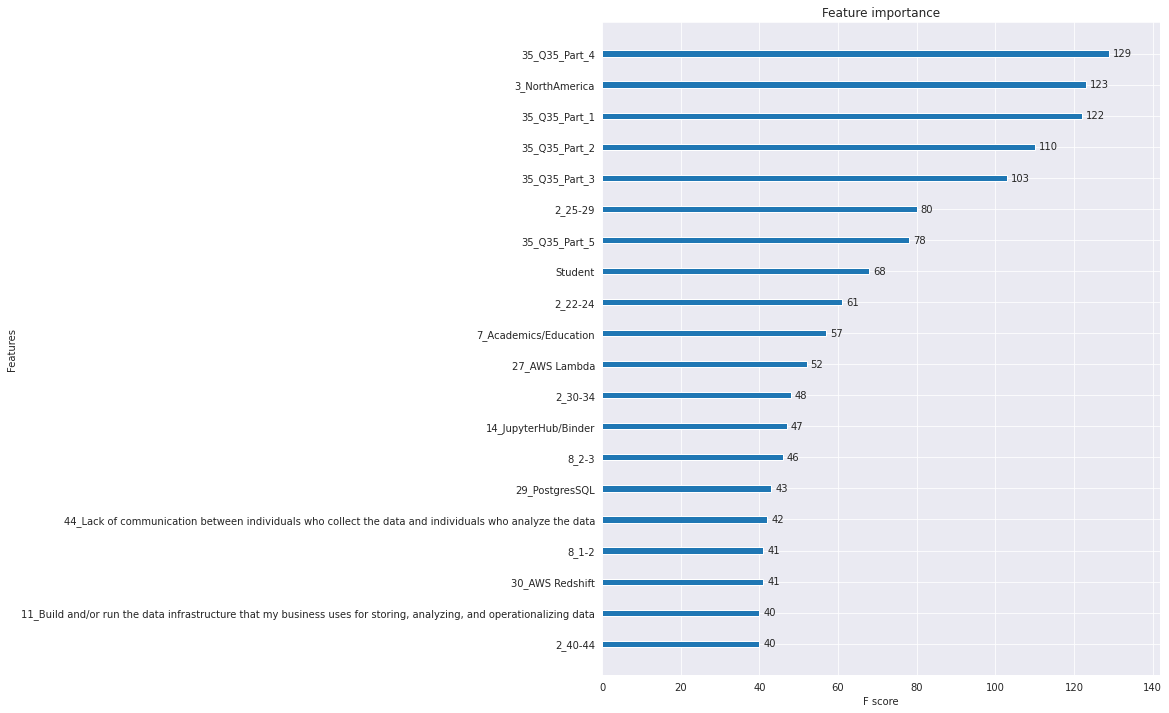

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax, max_num_features = 20)

xgboost 상으로는 Q35 Part 4가 가장 기여도가 높게 나타났다. (대학)
그 뒤 북미, 다른 Q35 parts, (selft taught, in online course, at work) 
그 뒤, Age 25-29가, 그리고 Student 역시 Salary의 중요하게 여겨지는 변수 중 하나로 계산되었다. 
* 클라우드 서비스 사용 중에는 AWS lambda가 의외로 중요 변수로 여겨졌다. 

** XGboost CV Score : 

In [ ]:
XGB_auc2 = cross_val_score(xgb_wrapper, X=Xg_train, y=y_train, scoring="roc_auc")
XGB_auc2

array([0.89812131, 0.90444845, 0.89725797, 0.91136634, 0.91209891])

In [ ]:
XGB_auc2.mean()

0.9046585975787421

In [ ]:
import xgboost as xgb

hr_dmatrix = xgb.DMatrix(data=Xg_train, label=y_train)

In [ ]:
cv_params = {"objective":"binary:logistic", 
             "n_estimators": 100,
             "max_depth":5}

hr_cv = xgb.cv(dtrain=hr_dmatrix, 
               params=cv_params, 
               nfold=5, 
               num_boost_round=10, 
               metrics="auc", 
               as_pandas=True)
hr_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.883834,0.003335,0.862155,0.013841
1,0.902118,0.003998,0.878134,0.012261
2,0.911106,0.003419,0.885499,0.013122
3,0.915818,0.003229,0.889128,0.010708
4,0.920159,0.002625,0.893085,0.010411
5,0.925451,0.001943,0.894900,0.008749
6,0.928293,0.001835,0.897433,0.007911
7,0.932132,0.001982,0.900101,0.007893
8,0.935398,0.001228,0.900781,0.007131
9,0.938189,0.001463,0.900852,0.007552


In [ ]:
XGB_cv_auc = hr_cv.iloc[:, 2].mean()
XGB_cv_auc

0.8902069000000001

## Model Comparison 


### By Cross Validation Score - AUC

In [ ]:
CV_table = pd.DataFrame()

CV_table.loc[1,'RF_cv_auc'] = RF_cv_score
CV_table['LR_cv_auc'] = LR_cv_score
CV_table['SVM_cv_auc'] = svm_scores.mean()
CV_table['XGB_cv_auc_cross_val'] = XGB_auc2.mean()
CV_table['XGB_cv_auc_xgb.cv'] = XGB_cv_auc

## Test Data Accuracy and ROC
Acc_table = pd.DataFrame()

Acc_table.loc[1,'RF_acc'] = RF_accuracy
Acc_table['LR_acc'] = LR_accuracy
Acc_table['SVM_acc'] = SVM_acc
Acc_table['XGB_acc'] = XGB_accuracy

AUC_table = pd.DataFrame()

AUC_table.loc[1,'RF_auc'] = RF_roc
AUC_table['LR_auc'] = LR_roc
AUC_table['SVM_auc'] = "None"
AUC_table['XGB_cv_auc'] = XGB_auc


In [ ]:
CV_table

,RF_cv_auc,LR_cv_auc,SVM_cv_auc,XGB_cv_auc_cross_val,XGB_cv_auc_xgb.cv
1,0.894543,0.906532,0.90232,0.904659,0.890207


In [ ]:
Acc_table

,RF_acc,LR_acc,SVM_acc,XGB_acc
1,0.857569,0.869128,0.864653,0.869873


In [ ]:
AUC_table

,RF_auc,LR_auc,SVM_auc,XGB_cv_auc
1,0.882457,0.895473,None,0.767261


* Final Result : 
- Cross validation 기준 : XGboost or Logistic Regression 중 선택. 
- Accuracy 기준 : Logistic Regression, SVM, XGB 모두 유사 
- AUC 기준 : Logistic Regression이 Best 

=> 따라서, Logistic Regression 및 XGB로 Parameter Tuning 실시. 

## Parameter Tuning 


* Logistic Regression Tunign : L1 vs L2 penalty, C - cost value

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Create a logistic regression object with an L2 penalty
logistic = LogisticRegression(solver='liblinear')

pipe = Pipeline(steps=[('logistic', logistic)])

# Create Parameter Space

# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,x_train.shape[1]+1,1))

# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)
# Create a list of options for the regularization penalty
penalty = ['l1', 'l2']
# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(x_train, y_train)
    # View The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
print(); print(clf.best_estimator_.get_params()['logistic'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Penalty: l1
Best C: 0.3906939937054613

LogisticRegression(C=0.3906939937054613, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

[0.87939297 0.88178914 0.86900958 0.88409273 0.89128697]

0.8811142779067481

0.007242882788351013


In [ ]:
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())


[0.90046004 0.91027299 0.90109641 0.91765022 0.92081251]

0.9100584333884953

0.008315989029903078


In [ ]:
Logistic = LogisticRegression(solver='liblinear', penalty = 'l1', C = clf.best_estimator_.get_params()['logistic__C'] )
Logistic.fit(x_train, y_train)

LR_pred = Logistic.predict(x_test)
LR_pred_score = Logistic.predict_proba(x_test)
# calculating metrics

LR_tuned_accuracy = accuracy_score(y_test, LR_pred)
LR_tuned_roc = roc_auc_score(y_test, pd.DataFrame(LR_pred_score)[1])

In [ ]:
print(LR_tuned_accuracy, LR_tuned_roc)

0.8747203579418344 0.8993545509627037


* 전부 tuning 전보다 미세하게나마 상승함. (Test accuracy, test AUC)

* XGB Hyper Parameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier()

# 초모수 격자생성
xgb_param_grid = {'max_depth': [3,5,7, 9], 
              'subsample': [0.6, 0.8, 1.0]}

# Create a GridSearchCV object
hr_grid = GridSearchCV(estimator=xgb_clf,
                       param_grid=xgb_param_grid,
                       scoring='roc_auc',
                       n_jobs=8,
                       cv=5,
                       refit=True, 
                       return_train_score=True)

hr_grid.fit(Xg_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'subsample': [0.6, 0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [ ]:
hr_grid_df = pd.DataFrame(hr_grid.cv_results_)
hr_grid_df.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,0.909820,"{'max_depth': 3, 'subsample': 0.6}"
1,0.910830,"{'max_depth': 3, 'subsample': 0.8}"
2,0.910336,"{'max_depth': 3, 'subsample': 1.0}"
3,0.908124,"{'max_depth': 5, 'subsample': 0.6}"
4,0.908723,"{'max_depth': 5, 'subsample': 0.8}"
5,0.910228,"{'max_depth': 5, 'subsample': 1.0}"
6,0.905836,"{'max_depth': 7, 'subsample': 0.6}"
7,0.909722,"{'max_depth': 7, 'subsample': 0.8}"
8,0.907742,"{'max_depth': 7, 'subsample': 1.0}"
9,0.906459,"{'max_depth': 9, 'subsample': 0.6}"


In [ ]:
hr_grid_df[hr_grid_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,19.039781,0.393132,0.08953,0.005396,3,0.8,"{'max_depth': 3, 'subsample': 0.8}",0.905462,0.910674,0.908571,0.917064,0.91238,0.91083,0.003878,1,0.947899,0.946067,0.946908,0.945645,0.946621,0.946628,0.000771


In [ ]:
## 최고성능
best_score = hr_grid.best_score_
# 최고성능을 내는 행을 찾아냄
best_row = hr_grid.best_index_

# 최적 초모수: max_depth, subsample
best_max_depth     = hr_grid.best_params_["max_depth"]
best_max_subsample = hr_grid.best_params_["subsample"]

nl = '\n'
print(f'Area Under ROC Cureve (AUC):  \t {best_score:.3f}{nl}\
        인덱스:           \t {best_row}{nl}\
        max_depth:      \t {best_max_depth}{nl}\
        subsample:      \t {best_max_subsample}')

Area Under ROC Cureve (AUC):  	 0.911
        인덱스:           	 1
        max_depth:      	 3
        subsample:      	 0.8


In [ ]:
xgb_tuned = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = best_max_depth,
                            eval_metric = "auc", early_stopping_rounds=100, subsample=best_max_subsample)
xgb_tuned.fit(Xg_train, y_train)
w_preds = xgb_tuned.predict(Xg_test)

In [ ]:
get_clf_eval(y_test, w_preds)

오차행렬:
 [[1996  126]
 [ 219  341]]

정확도: 0.8714
정밀도: 0.7302
재현율: 0.6089
F1: 0.6641
AUC: 0.7748


In [ ]:
XGB_tuned_accuracy = accuracy_score(y_test, w_preds)
XGB_tuned_auc = roc_auc_score(y_test, w_preds)

In [ ]:
XGB_tuned_cv_Result = cross_val_score(xgb_tuned, Xg_train, y_train, cv=5, scoring='roc_auc')
XGB_tuned_cv_Result.mean()

0.9057078403666804

In [ ]:
print("_______Comparison from Former Logistic Regression______ \n")
print("* Accuracy : \n LR_accuracy = {}, LR_tuned_accuracy = {}" .format(LR_accuracy, LR_tuned_accuracy))
print("* Area Under Roc Curve : \n LR_auc = {}, LR_tuned_auc = {}" .format(LR_roc, LR_tuned_roc))
print("* Cross Validation Score : \n LR_cv_auc = {}, LR_cv_tuned_auc = {}" .format(LR_cv_score, CV_Result.mean()))

print("_______Comparison from Former XGBoost______ \n")
print("* Accuracy : \n XGB_accuracy = {}, XGB_tuned_accuracy = {}" .format(XGB_accuracy, XGB_tuned_accuracy))
print("* Area Under Roc Curve : \n XGB_auc = {}, XGB_tuned_auc = {}" .format(XGB_auc, XGB_tuned_auc))
print("* Cross Validation Score(using cross_val_score) : \n XGB_cv_auc = {}, XGB_cv_tuned_auc = {}" .format(XGB_auc2.mean(), XGB_tuned_cv_Result.mean()))
print("* Cross Validation Score(using GridSearchCV) : \n XGB_cv_auc = {}, XGB_cv_tuned_auc = {}" .format(XGB_cv_auc, best_score))

_______Comparison from Former Logistic Regression______ 

* Accuracy : 
 LR_accuracy = 0.8691275167785235, LR_tuned_accuracy = 0.8747203579418344
* Area Under Roc Curve : 
 LR_auc = 0.8954734414972398, LR_tuned_auc = 0.8993545509627037
* Cross Validation Score : 
 LR_cv_auc = 0.9065319710836457, LR_cv_tuned_auc = 0.9100584333884953
_______Comparison from Former XGBoost______ 

* Accuracy : 
 XGB_accuracy = 0.8698732289336316, XGB_tuned_accuracy = 0.8713646532438478
* Area Under Roc Curve : 
 XGB_auc = 0.7672605022216237, XGB_tuned_auc = 0.7747753130469907
* Cross Validation Score(using cross_val_score) : 
 XGB_cv_auc = 0.9046585975787421, XGB_cv_tuned_auc = 0.9057078403666804
* Cross Validation Score(using GridSearchCV) : 
 XGB_cv_auc = 0.8902069000000001, XGB_cv_tuned_auc = 0.9108301076140487


## Final Model 선택 : 
- Logistic Regression이 test accuracy, cross validation score, test auc 모두에서 훨씬 더 높은 결과를 가져옴. 
- Logistic Regression을 최종 모델로 채택. 

In [ ]:
display_scores(Logistic, x_test, y_test)


### -- ### -- LogisticRegression -- ### -- ###
Confusion Matrix:  [[2009  113]
 [ 223  337]]
Accuracy:  0.8747203579418344
AUC:  0.8993545509627037
Type 1 error:  0.053251649387370405
Type 2 error:  0.3982142857142857


In [ ]:
import plotly.graph_objects as go

def gen_layout(charttitle, xtitle, ytitle, annotations=None, lmarg=120, h=400):  
    """
    Create layout
    """
    return go.Layout(title=charttitle, 
                     height=h, 
                     width=800,
                     showlegend=False,
                     xaxis=gen_xaxis(xtitle), 
                     yaxis=gen_yaxis(ytitle),
                     annotations = annotations,
                     margin=dict(l=lmarg),
                    )

* ROC curve graph : 

In [ ]:
print('Our model\'s intercept is:', Logistic.intercept_[0])

Our model's intercept is: 0.0


= Intercept Starts with 0.___ => 여기에서 본인이 가진 특징으로 가감되어 최종 Top20안에 드는 연봉을 받을 수 있는가가 결정됨. 
* Psotive Coefficients : positive 답변이 Top 20% 연봉 안에 들 확률을 높인다.
* Negative Coefficients : positive 답변이 Top 20% 연봉 안에 들 확률을 낮춘다. 

* Coefficients 

In [ ]:
features = pd.DataFrame([x_train.columns, Logistic.coef_[0]]).transpose()
features.columns = ['feature', 'coefficient']
features['abs_coefficient'] = features['coefficient'].abs()

In [ ]:
features.iloc[0:15, :]

,feature,coefficient,abs_coefficient
0,1_Female,0,0
1,1_Male,-0.0195892,0.0195892
2,2_18-21,-1.31279,1.31279
3,2_22-24,-1.94017,1.94017
4,2_25-29,-1.5102,1.5102
5,2_30-34,-0.876915,0.876915
6,2_35-39,-0.104736,0.104736
7,2_40-44,-0.223461,0.223461
8,3_Asia,-0.148486,0.148486
9,3_Europe,-0.287771,0.287771


In [ ]:
features.tail()

,feature,coefficient,abs_coefficient
240,48_I am confident that I can explain the outpu...,-0.00845743,0.00845743
241,48_I am confident that I can understand and ex...,-0.00774824,0.00774824
242,48_I do not know; I have no opinion on the matter,0,0
243,"48_I view ML models as ""black boxes"" but I am ...",-0.109307,0.109307
244,"48_Yes, most ML models are ""black boxes""",0.0215805,0.0215805


In [ ]:
features['question_number'] = features.feature.str.split('_').str[0]

features['answer'] = features.feature.str[2:]

features['answer'] = features.answer.apply(lambda x: x[1:] if x[0] == '-' else x)
features['question'] = features['question_number']

In [ ]:
features.iloc[40:60, :]

,feature,coefficient,abs_coefficient,question_number,answer,question
40,"10_We recently started using ML methods (i.e.,...",0.0114346,0.0114346,10,"_We recently started using ML methods (i.e., m...",10
41,10_We use ML methods for generating insights (...,0,0,10,_We use ML methods for generating insights (bu...,10
42,11_Analyze and understand data to influence pr...,-0.0053542,0.0053542,11,_Analyze and understand data to influence prod...,11
43,11_Build and/or run a machine learning service...,0.0804388,0.0804388,11,_Build and/or run a machine learning service t...,11
44,11_Build and/or run the data infrastructure th...,0.0382396,0.0382396,11,_Build and/or run the data infrastructure that...,11
45,11_Build prototypes to explore applying machin...,0.571208,0.571208,11,_Build prototypes to explore applying machine ...,11
46,11_Do research that advances the state of the ...,-0.0443916,0.0443916,11,_Do research that advances the state of the ar...,11
47,11_Other,0.0775768,0.0775768,11,_Other,11
48,12_Q12_Part_2_TEXT,0.0797841,0.0797841,12,_Q12_Part_2_TEXT,12
49,12_Q12_Part_3_TEXT,0,0,12,_Q12_Part_3_TEXT,12


In [ ]:
import plotly.graph_objects as go


In [ ]:
Q6_data = features.iloc[15:21, :]
Q6_data
title = "6_What is Your Role?"
barplot = Q6_data[['feature', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q6_data.feature, y = Q6_data.coefficient)])
fig.show()

* L1 Penalty : 효과가 미미한 경우 0으로 보내버림. 따라서 Data Engineer/DBA와 Software Engineer의 효과가 사라짐. 

In [ ]:
Q4_data = features.iloc[12:15, :]
Q4_data
title = "4_What is the Highest Level of formal education that you have attained or plan to attain within the next 2 years?"
barplot = Q4_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = False)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q4_data.answer, y = Q4_data.coefficient)])
fig.show()

* Bachelor's degree는 비교적 효과 없음으로 드러남. Doctoral과 Master's degree 는 top 20% 연봉에 유의한 결과를 드러냄. 

In [ ]:
Q8_data = features.iloc[29:36, :]
Q8_data = Q8_data.astype(object)

title = "8_How many years of experience do you have in your current role?"
barplot = Q8_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q8_data.answer, y = Q8_data.coefficient)])
fig.show()

* 전부 Negative coefficients.
* 5~10년, 10-15년 경력이 그래도 가장 작은 coef
* 높은 경력자 = 많은 연봉. 

* Q11

In [ ]:
Q11_data = features.iloc[42:48, :]

title = "11_Select any activities that make up an important part of your role at work"
barplot = Q11_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q11_data.answer, y = Q11_data.coefficient)])
fig.show()

* Building Prototype to explore ML to new areas 가 가장 높은 coef를 갖는 것으로 나타남. 
* 그 뒤로는 Build and/or run a service that operationally ~~


 * 24 : 데이터 분석을 위해 코딩을 해 온 경력 : 

In [ ]:
Q24_data = features.iloc[117:127, :]
title = "Q24"
barplot = Q24_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q24_data.answer, y = Q24_data.coefficient)])
fig.show()

* 코딩 경력 = 많을 수록 좋은 salary.
* 보통 코딩 경력 낮을 수록 연봉 top 20% 안에 들어갈 확률에 -값을 더함. 

* Q34

In [ ]:
Q35_data = features.iloc[232:237, :]

title = "Q35"
barplot = Q35_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q35_data.answer, y = Q35_data.coefficient)])
fig.show()

* Q35 part 4가 positive corr 보유. = university 

* Q36 : on which online platforms have you begun or complete data science cources?

In [ ]:
Q36_data = features.iloc[164:175:, :]

title = "Q36"
barplot = Q36_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q36_data.answer, y = Q36_data.coefficient)])
fig.show()

* Udacity - positive corr to top 20% salary kaggers. 
* Udemy, Datacamp - negative coef to top 20% salary kagglers => I guess, 초보자들이 많이 듣는 강의사이트? 

* Q31 - Which types of data do you currently interact with most often at work or school?

In [ ]:
Q31_data = features.iloc[154:164:, :]
title = "Q31"
barplot = Q31_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q31_data.answer, y = Q31_data.coefficient)])
fig.show()

* top 20% 연봉 kagglers - 주로 Genetic Data, Geospatial Data, Image Data를 다룸,
* 전문가 = 고학력자 = 특수 분야 이렇게 연관성이 있는듯 하다. 
* Categorical, Text data, Numeric Data ; 상당히 낮은 coefficients
=> Genentic/Geospatial/Image -> Boost.


* Q40 : Which better demonstrates expertise in data science : academic achievement or independent projects? 


In [ ]:
Q40_data = features.iloc[237:240, :]
title = "Q40"
barplot = Q40_data[['answer', 'coefficient']].copy()
barplot.columns = ['y', 'x']
barplot = barplot.sort_values(by='x', ascending = True)
barplot['model_highlight'] = barplot.x > 0
barplot['color'] = barplot.model_highlight.apply(lambda x :'cornflowerblue' if x else 'a')

fig = go.Figure([go.Bar(x = Q40_data.answer, y = Q40_data.coefficient)])
fig.show()

Top 20% dont' think independent projects are equally important as academic achievement. 

* Variable importance Plot 

In [ ]:
index_clean = clean_dataset.columns[2:]
index_clean

Index(['1_Female', '1_Male', '2_18-21', '2_22-24', '2_25-29', '2_30-34',
       '2_35-39', '2_40-44', '3_Asia', '3_Europe',
       ...
       '35_Q35_Part_4', '35_Q35_Part_5',
       '40_Independent projects are equally important as academic achievements',
       '40_Independent projects are much more important than academic achievements',
       '40_Independent projects are slightly more important than academic achievements',
       '48_I am confident that I can explain the outputs of most if not all ML models',
       '48_I am confident that I can understand and explain the outputs of many but not all ML models',
       '48_I do not know; I have no opinion on the matter',
       '48_I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       '48_Yes, most ML models are "black boxes"'],
      dtype='object', length=245)

In [ ]:
feature_imp = pd.Series(rforest.feature_importances_, index=index_clean).sort_values(ascending = False)
feature_imp[0:20]

3_NorthAmerica                                                                               0.096702
Student                                                                                      0.017915
24_10-20 years                                                                               0.017662
38_FiveThirtyEight.com                                                                       0.014500
35_Q35_Part_1                                                                                0.014489
3_Asia                                                                                       0.013871
35_Q35_Part_3                                                                                0.013780
3_Europe                                                                                     0.012493
35_Q35_Part_2                                                                                0.012118
35_Q35_Part_4                                                                     

<Salary 공개한 사람들의 특징>
* North America = 미국이 대체로 높은 연봉에 주요한 요인을 차지. 
* Q34 제외했더니 Q35 Part 1이 치고올라옴. (독학)
* Q38 - FiveThirtyEight.com에서 주로 ML 관련 기사 많이 봄.
* 경력 10-20years
* Asia가 역시 유의
* Students 역시 유의(연봉 작음)
* AWS를 많이 쓰는듯
* 주로 DS일수록 고연봉자
* AWS도 꽤 Importance가 높게 나타남. 
* 회사에서 ML을 잘 정립 할수록 연봉이 높게 나타남. 
* Age : 25-29, 


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_tuned, ax=ax, max_num_features = 20)

## After Tuned : 
- Q35가 전부 상위로 치고 올라왔다. 
- 그 뒤가 North America
- 나이 25-29와 Student는 계속 상위권에 존재.
- Academics/Education industry도 계속 잔존. 
